# Import Libraries

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

from imblearn.over_sampling import SMOTE

# Basic overview of the data

In [41]:
# Import datasets
train_df = pd.read_csv("csv_files/train.csv")
test_df = pd.read_csv("csv_files/test.csv")

print('Training dataset: ')
display(train_df.head(3))

print('Testing dataset: ')
display(test_df.head(3))

# Check for any duplicates
print(f"Duplicates in Train Dataset is:{train_df.duplicated().sum()},({100*train_df.duplicated().sum()/len(train_df)})%")
print(f"Duplicates in Test Dataset is:{test_df.duplicated().sum()},({100*test_df.duplicated().sum()/len(test_df)})%")


Training dataset: 


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


Testing dataset: 


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus


Duplicates in Train Dataset is:0,(0.0)%
Duplicates in Test Dataset is:0,(0.0)%


### Insights

1. There is no duplication so there is no need to drop duplicates. Acts more as a sanity check.

In [42]:
# Calculate missing data statistics for the training set
train_missing = train_df.isnull().sum()[train_df.isnull().sum() > 0].to_frame().rename(columns={0: "Number of Missing Values (Train)"})
train_missing["% of Missing Values (Train)"] = round((100 * train_missing["Number of Missing Values (Train)"] / len(train_df)), 2)

# Calculate missing data statistics for the testing set
test_missing = test_df.isnull().sum()[test_df.isnull().sum() > 0].to_frame().rename(columns={0: "Number of Missing Values (Test)"})
test_missing["% of Missing Values (Test)"] = round((100 * test_missing["Number of Missing Values (Test)"] / len(test_df)), 2)

# Combine the statistics into a single DataFrame by joining on the index (feature names)
combined_missing = train_missing.join(test_missing, how='outer')

# Reset the index to turn the index (feature names) into a regular column
combined_missing.reset_index(inplace=True)
combined_missing.rename(columns={"index": "Feature"}, inplace=True)

# Display the combined DataFrame
display(combined_missing)


,Feature,Number of Missing Values (Train),% of Missing Values (Train),Number of Missing Values (Test),% of Missing Values (Test)
0,Age,179,2.06,91,2.13
1,Cabin,199,2.29,100,2.34
2,CryoSleep,217,2.50,93,2.17
3,Destination,182,2.09,92,2.15
4,FoodCourt,183,2.11,106,2.48
5,HomePlanet,201,2.31,87,2.03
6,Name,200,2.30,94,2.20
7,RoomService,181,2.08,82,1.92
8,ShoppingMall,208,2.39,98,2.29
9,Spa,183,2.11,101,2.36


### Insights

1. There is a very small percentage of data missing in both training and testing data. 
2. It will be easily fillable with imputing more suitable values rather than dropping the rows.

In [43]:
print("cardinality of categorical features in training datasets is:")
print(train_df.select_dtypes(include="object").nunique())

print("\n","-"*70)

print("\nCardinality of categorical features in testing datsets is:")
print(test_df.select_dtypes(include="object").nunique())

cardinality of categorical features in training datasets is:
PassengerId    8693
HomePlanet        3
CryoSleep         2
Cabin          6560
Destination       3
VIP               2
Name           8473
dtype: int64

 ----------------------------------------------------------------------

Cardinality of categorical features in testing datsets is:
PassengerId    4277
HomePlanet        3
CryoSleep         2
Cabin          3265
Destination       3
VIP               2
Name           4176
dtype: int64


### Insights

1. We observe that the PassengerId, Cabin, and Name features of both datasets have high cardinality.
2. Typically, features with high cardinality are dropped. However, in this project, we will perform feature engineering and create new features from these features. 

# Deeper exploration of the data

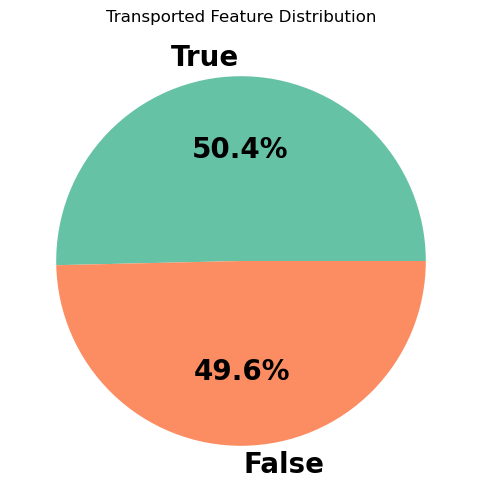

In [44]:
plt.figure(figsize=(10,6))
plt.pie(train_df["Transported"].value_counts(),labels=train_df["Transported"].value_counts().keys(),autopct="%1.1f%%",
       textprops={"fontsize":20,"fontweight":"black"},colors=sns.color_palette("Set2"))
plt.title("Transported Feature Distribution");

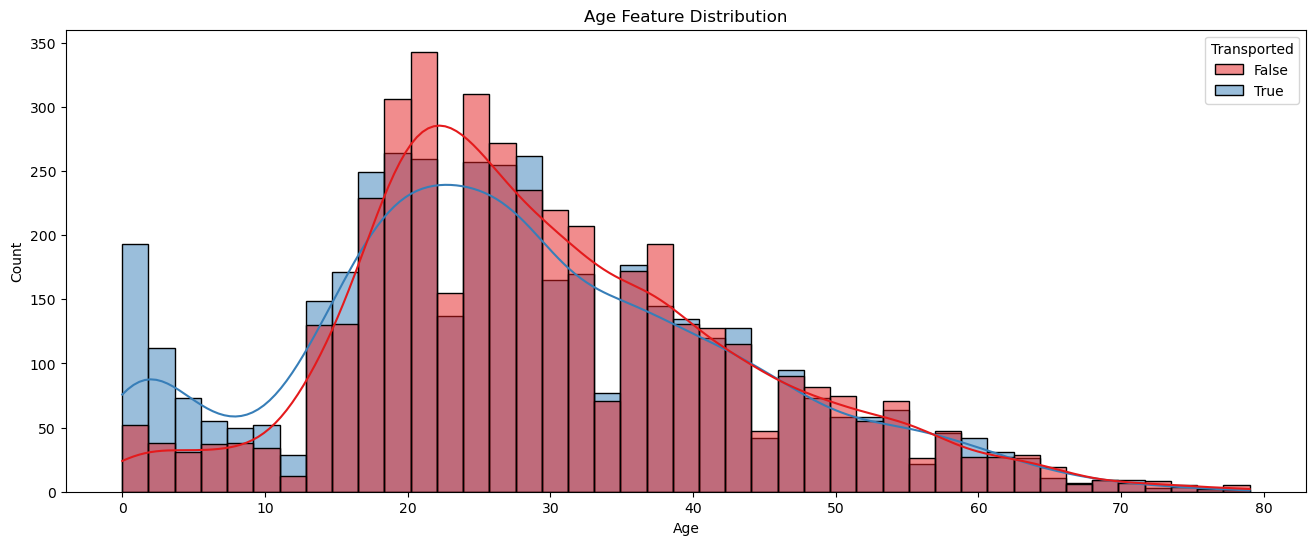

In [45]:
plt.figure(figsize=(16,6))
sns.histplot(x=train_df["Age"],hue="Transported",data=train_df,kde=True,palette="Set1")
plt.title("Age Feature Distribution");


- Most of the passengers were between the ages of 18-32.
- Passengers aged 0-18 are highly transported compared to not transported passengers, especially for those who were newborn.
- Passengers aged 18-32 are comparatively less transported compared to not transported passengers.
- Passengers above 32 seem to be equally transported compared to not transported passengers.


### Insights
We can create a new feature called Age-Category from age, in which we can split ages into different categories.


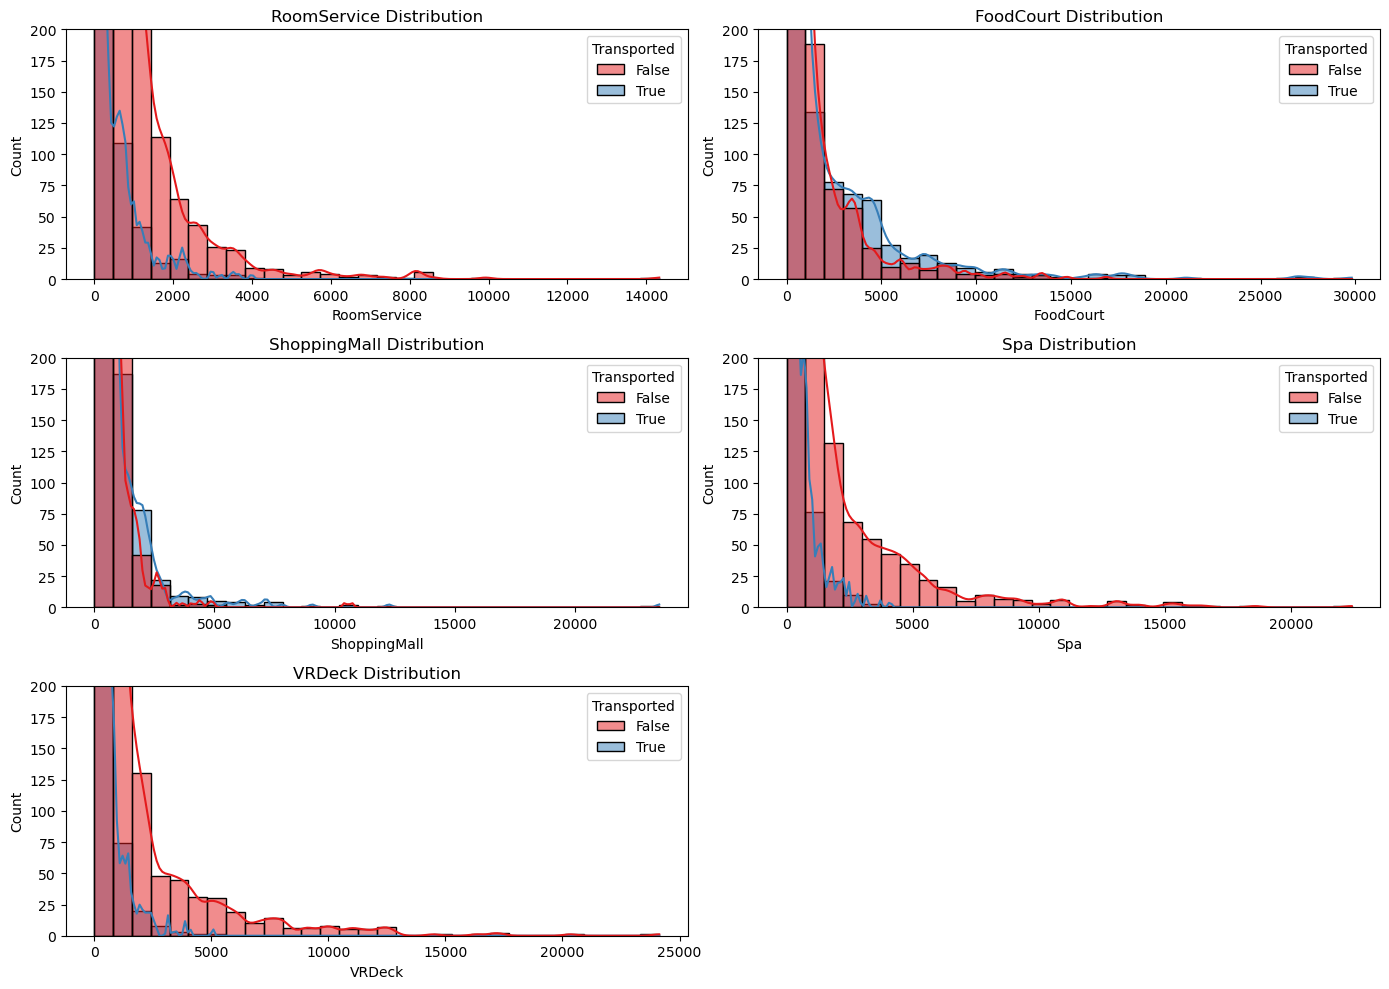

In [46]:
exp_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

plt.figure(figsize=(14,10))
for idx,column in enumerate(exp_cols):
    plt.subplot(3,2,idx+1)
    sns.histplot(x=column, hue="Transported", data=train_df,bins=30,kde=True,palette="Set1")
    plt.title(f"{column} Distribution")
    plt.ylim(0,200)
    plt.tight_layout()

### Insights

- Since all expenditure features have right-skewed distributions, we will transform these features to normal distributions using log-transformation before model building.
- We can create a new feature called Total Expenditure, indicating the total expenses of all different expenditures done by the passengers.
- Since most people's expenses are 0, we can create a new boolean feature called No Spending, indicating whether the passenger's total expense is 0 or not.
- We can split Total Expenditure into different categories of expenditure like Low, Medium, and High Expenses and create another new feature called Expenditure Category.


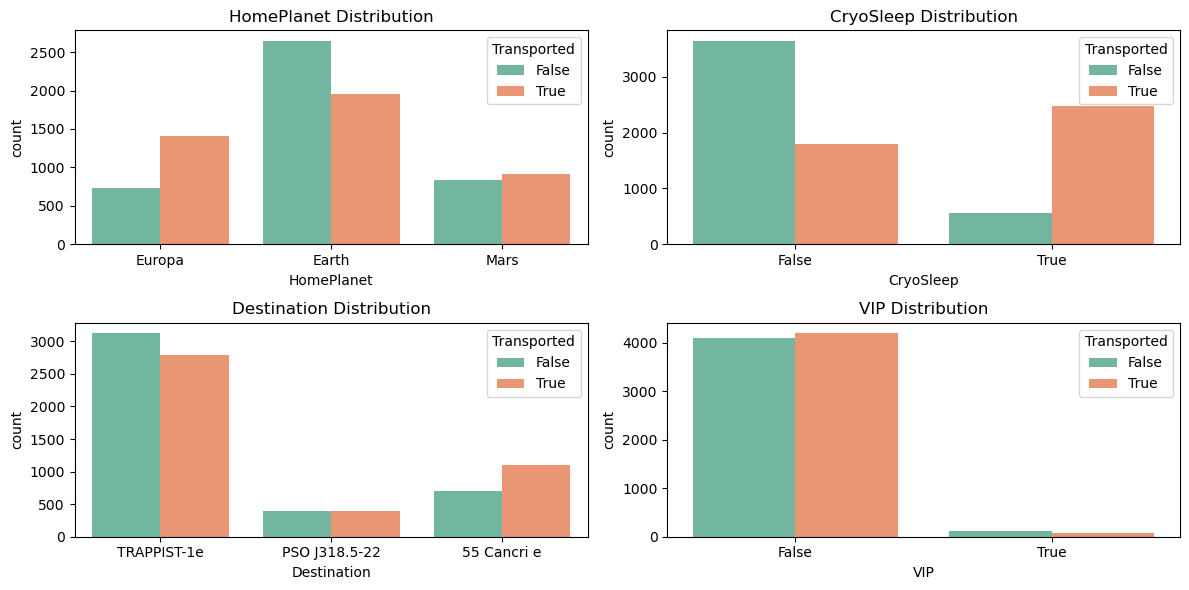

In [47]:
cat_cols = ["HomePlanet", "CryoSleep", "Destination", "VIP"]

# Create a 2x2 subplot grid and set the overall figure size
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

# Iterate over the columns and the corresponding axes
for idx, column in enumerate(cat_cols):
    # Create a countplot for each categorical column on its respective axis
    sns.countplot(x=column, hue="Transported", data=train_df, palette="Set2", ax=axes_flat[idx])
    # Set the title for each subplot
    axes_flat[idx].set_title(f"{column} Distribution")

plt.tight_layout()
plt.show()


### Insights
- In the HomePlanet feature, we observe that most passengers are from Earth. However, passengers from Earth are comparatively less transported, passengers from Mars are equally transported, and passengers from Europa are highly transported.
- In the Destination feature, we observe that most passengers are transported to Trappist-1e.
- Regarding the VIP feature, one category is dominating significantly over the others. Therefore, this feature doesn't seem to be useful and may lead to overfitting in our model.
- It's advisable to drop the VIP feature before building the model.

# Feature Engineering

### Feature engineering on PassangerID

- Each ID takes the form gggg_pp, where gggg indicates the group the passenger is traveling with and pp is their number of people within the group.
- To perform feature engineering on the PassengerId, we will create a new feature called Group_Size, indicating the total number of members present in each group.
- Additionally, we will create another new feature called Travelling Solo, indicating whether the passenger is traveling solo or in a group.</li>


In [48]:
def passengerid_new_features(df):
    
    #Splitting Group and Member values from "PassengerId" column.
    df["Group"] = df["PassengerId"].apply(lambda x: x.split("_")[0])
    df["Member"] =df["PassengerId"].apply(lambda x: x.split("_")[1])
    
    #Grouping the "Group" feature with respect to "member" feature to check which group is travelling with how many members
    x = df.groupby("Group")["Member"].count().sort_values()
    
    #Creating a set of group values which are travelling with more than 1 members.
    y = set(x[x>1].index)
    
    #Creating a new feature "Solo" which will indicate whether the person is travelling solo or not.
    df["Travelling_Solo"] = df["Group"].apply(lambda x: x not in y)
    
    #Creating a new feature "Group_size" which will indicate each group number of members.
    df["Group_Size"]=0
    for i in x.items():
        df.loc[df["Group"]==i[0],"Group_Size"]=i[1]
    
    # Remove 'Group' and 'Member' as we got group size and travel solo
    df.drop(columns=["Group","Member"],inplace=True)

passengerid_new_features(train_df)
passengerid_new_features(test_df)

display(train_df.head(3))

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Travelling_Solo,Group_Size
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,True,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,True,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,False,2


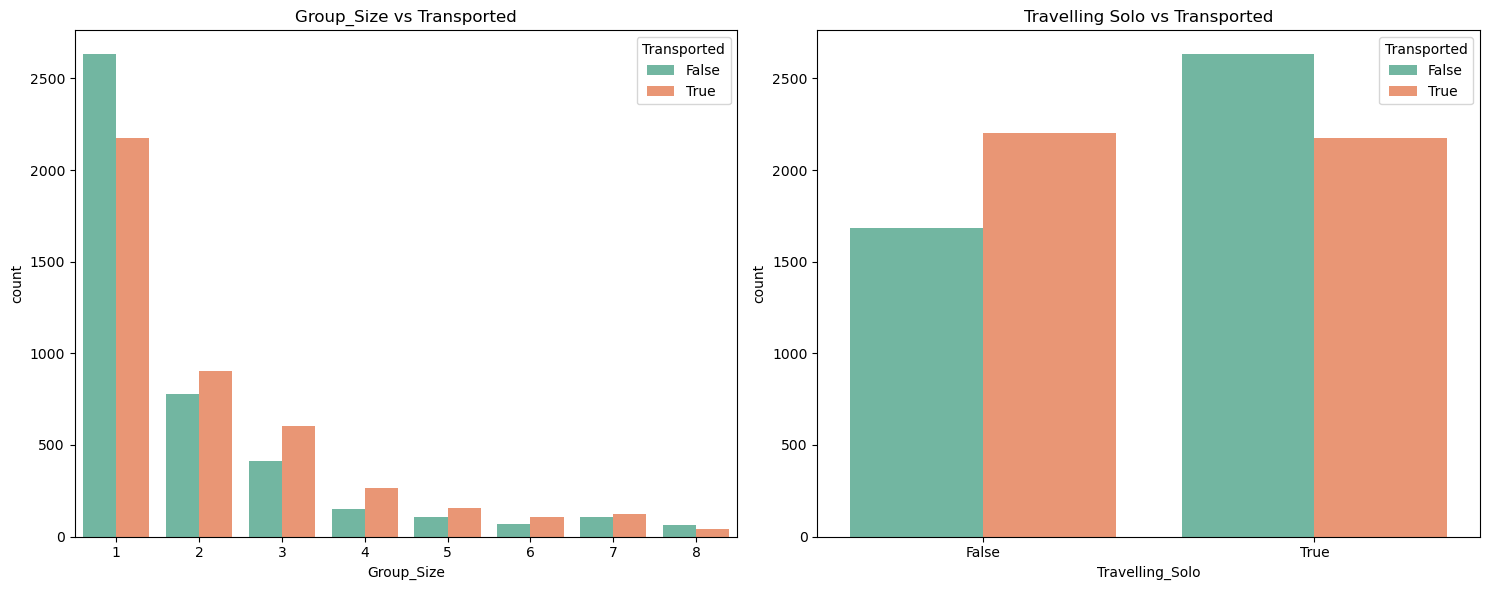

In [49]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sns.countplot(x="Group_Size", hue="Transported", data=train_df,palette="Set2")
plt.title("Group_Size vs Transported")

plt.subplot(1,2,2)
sns.countplot(x="Travelling_Solo", hue="Transported", data=train_df,palette="Set2")
plt.title("Travelling Solo vs Transported")
plt.tight_layout()
plt.show()

### Observation

- In the Group_Size feature, it's evident that most passengers are traveling alone.
- However, from the Travelling_Solo feature, we observe that passengers traveling solo are comparatively less transported when compared with passengers traveling in a group. 


### How will we do feature engineering on Cabin
- We understand that the cabin feature consists of deck/num/side, where deck represents the deck location, num represents the deck number, and side can be P for port or S for Starboard.
- To perform feature engineering on the Cabin feature, we will separate these three values and create three new features: Cabin_Deck, Cabin_Number, and Cabin_Side.
- Additionally, since the Cabin feature contains NaN values, we need to handle them appropriately to avoid errors during splitting. We will replace the NaN values in such a way that they can be split into all three new features accordingly.


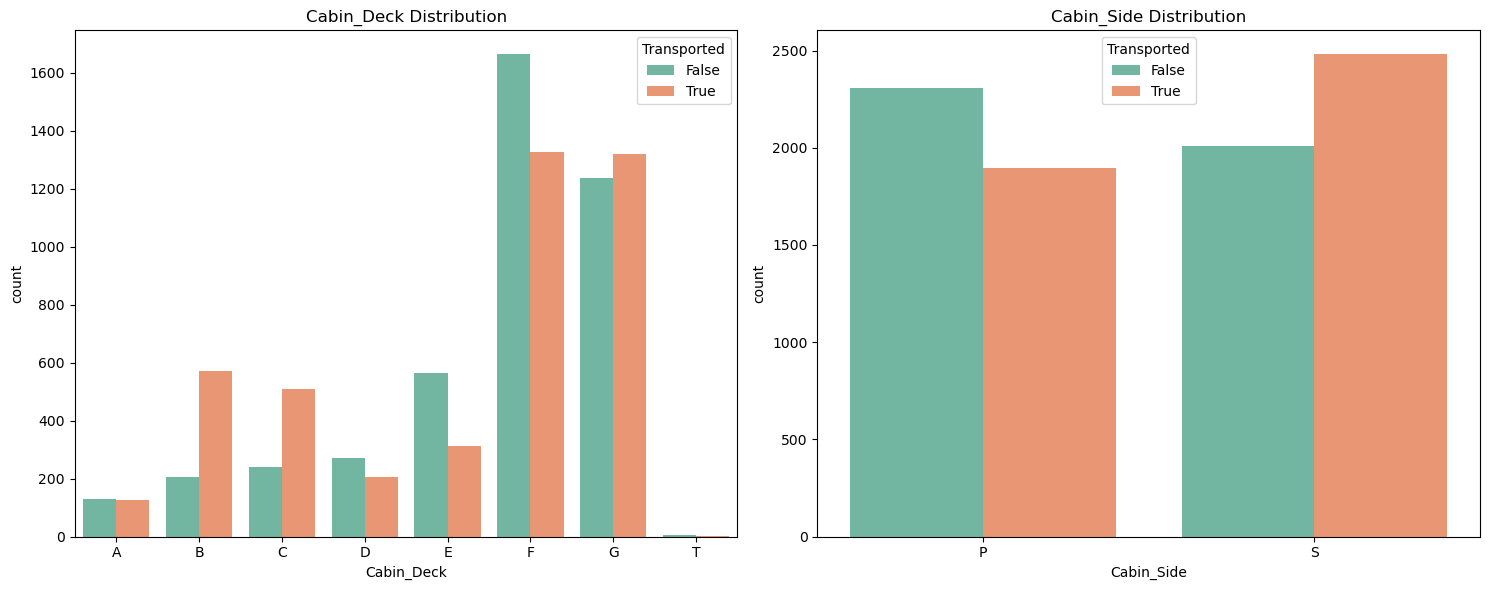

In [50]:
def cabin_new_feature(df):
    # Temporarily fill NaNs in 'Cabin' to facilitate splitting
    df["Cabin"].fillna("Unknown/Unknown/Unknown", inplace=True)
    
    # Split 'Cabin' into new features
    df["Cabin_Deck"] = df["Cabin"].apply(lambda x: x.split("/")[0])
    df["Cabin_Number"] = df["Cabin"].apply(lambda x: x.split("/")[1])
    df["Cabin_Side"] = df["Cabin"].apply(lambda x: x.split("/")[2])
    
    # Replace 'Unknown' with np.nan to facilitate numerical operations and maintain consistency
    cols = ["Cabin_Deck", "Cabin_Number", "Cabin_Side"]
    df[cols] = df[cols].replace("Unknown", np.nan)
    
    # Convert 'Cabin_Number' to numeric, errors='coerce' will convert non-numeric to NaN
    df["Cabin_Number"] = pd.to_numeric(df["Cabin_Number"], errors='coerce')
    
    # Fill missing values in new features
    df["Cabin_Deck"].fillna(df["Cabin_Deck"].mode()[0], inplace=True)
    df["Cabin_Side"].fillna(df["Cabin_Side"].mode()[0], inplace=True)
    df["Cabin_Number"].fillna(df["Cabin_Number"].median(), inplace=True)

cabin_new_feature(train_df)
cabin_new_feature(test_df)

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(x="Cabin_Deck",hue="Transported", data=train_df, palette="Set2",order=["A","B","C","D","E","F","G","T"])
plt.title("Cabin_Deck Distribution")

plt.subplot(1,2,2)
sns.countplot(x="Cabin_Side", hue="Transported", data=train_df, palette="Set2")
plt.title("Cabin_Side Distribution")
plt.tight_layout()
plt.show()

### Insights
- The majority of people are from Cabin_Deck F & G.
- There are very few passengers in Cabin_Deck T.
- Passengers from Cabin Deck B & C are transported at a high rate.
- From Cabin_Side, approximately half of the passengers were from cabin side S and half from cabin side P.
- However, passengers from cabin side S are transported at a higher rate compared to those from cabin side P, despite both sides having an equal number of passengers.

Total Unique values present in Cabin_Number feature is: 1817
The Mean of Cabin_Number Feature is:  596.3989416772115
The Median of Cabin_Number Feature is: 427.0
The Minimum value of Cabin_Number feature is: 0
The Maximum value of Cabin_number Feature is: 1894


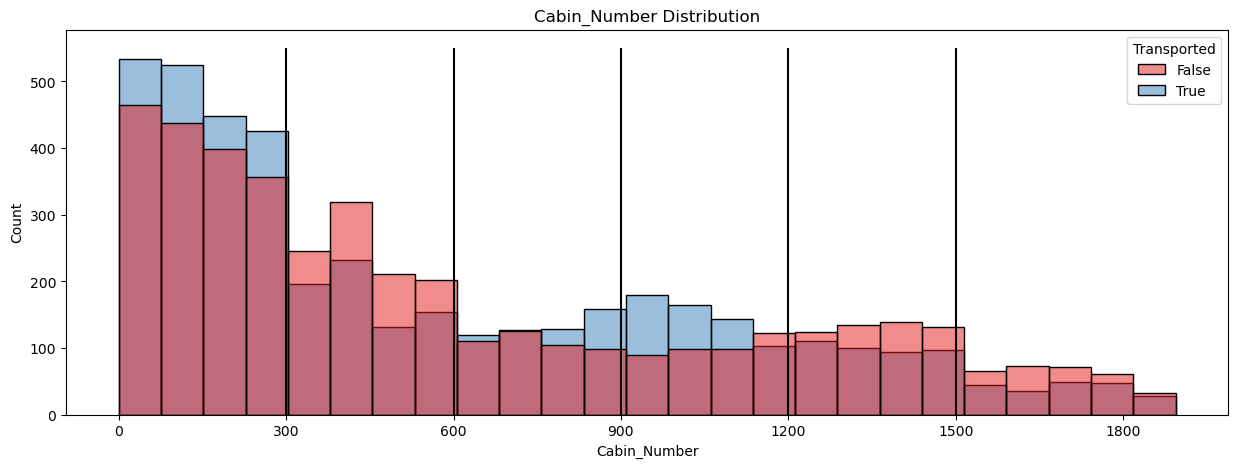

In [51]:
train_df["Cabin_Number"]=train_df["Cabin_Number"].astype(int)
test_df["Cabin_Number"]=test_df["Cabin_Number"].astype(int)

print("Total Unique values present in Cabin_Number feature is:",train_df["Cabin_Number"].nunique())
print("The Mean of Cabin_Number Feature is: ",train_df["Cabin_Number"].mean())
print("The Median of Cabin_Number Feature is:",train_df["Cabin_Number"].median())
print("The Minimum value of Cabin_Number feature is:",train_df["Cabin_Number"].min())
print("The Maximum value of Cabin_number Feature is:",train_df["Cabin_Number"].max())

plt.figure(figsize=(15,5))
sns.histplot(x="Cabin_Number",data=train_df,hue="Transported",palette="Set1")
plt.title("Cabin_Number Distribution")
plt.xticks(list(range(0,1900,300)))
plt.vlines(300,ymin=0,ymax=550,color="black")
plt.vlines(600,ymin=0,ymax=550,color="black")
plt.vlines(900,ymin=0,ymax=550,color="black")
plt.vlines(1200,ymin=0,ymax=550,color="black")
plt.vlines(1500,ymin=0,ymax=550,color="black")
plt.show()

In [52]:
def cabin_regions(df):
    df["Cabin_Region1"] = (df["Cabin_Number"]<300)
    df["Cabin_Region2"] = (df["Cabin_Number"]>=300) & (df["Cabin_Number"]<600)
    df["Cabin_Region3"] = (df["Cabin_Number"]>=600) & (df["Cabin_Number"]<900)
    df["Cabin_Region4"] = (df["Cabin_Number"]>=900) & (df["Cabin_Number"]<1200)
    df["Cabin_Region5"] = (df["Cabin_Number"]>=1200) & (df["Cabin_Number"]<1500)
    df["Cabin_Region6"] = (df["Cabin_Number"]>=1500)

    df.drop(columns=["Cabin_Number"],inplace=True)

cabin_regions(train_df)
cabin_regions(test_df)


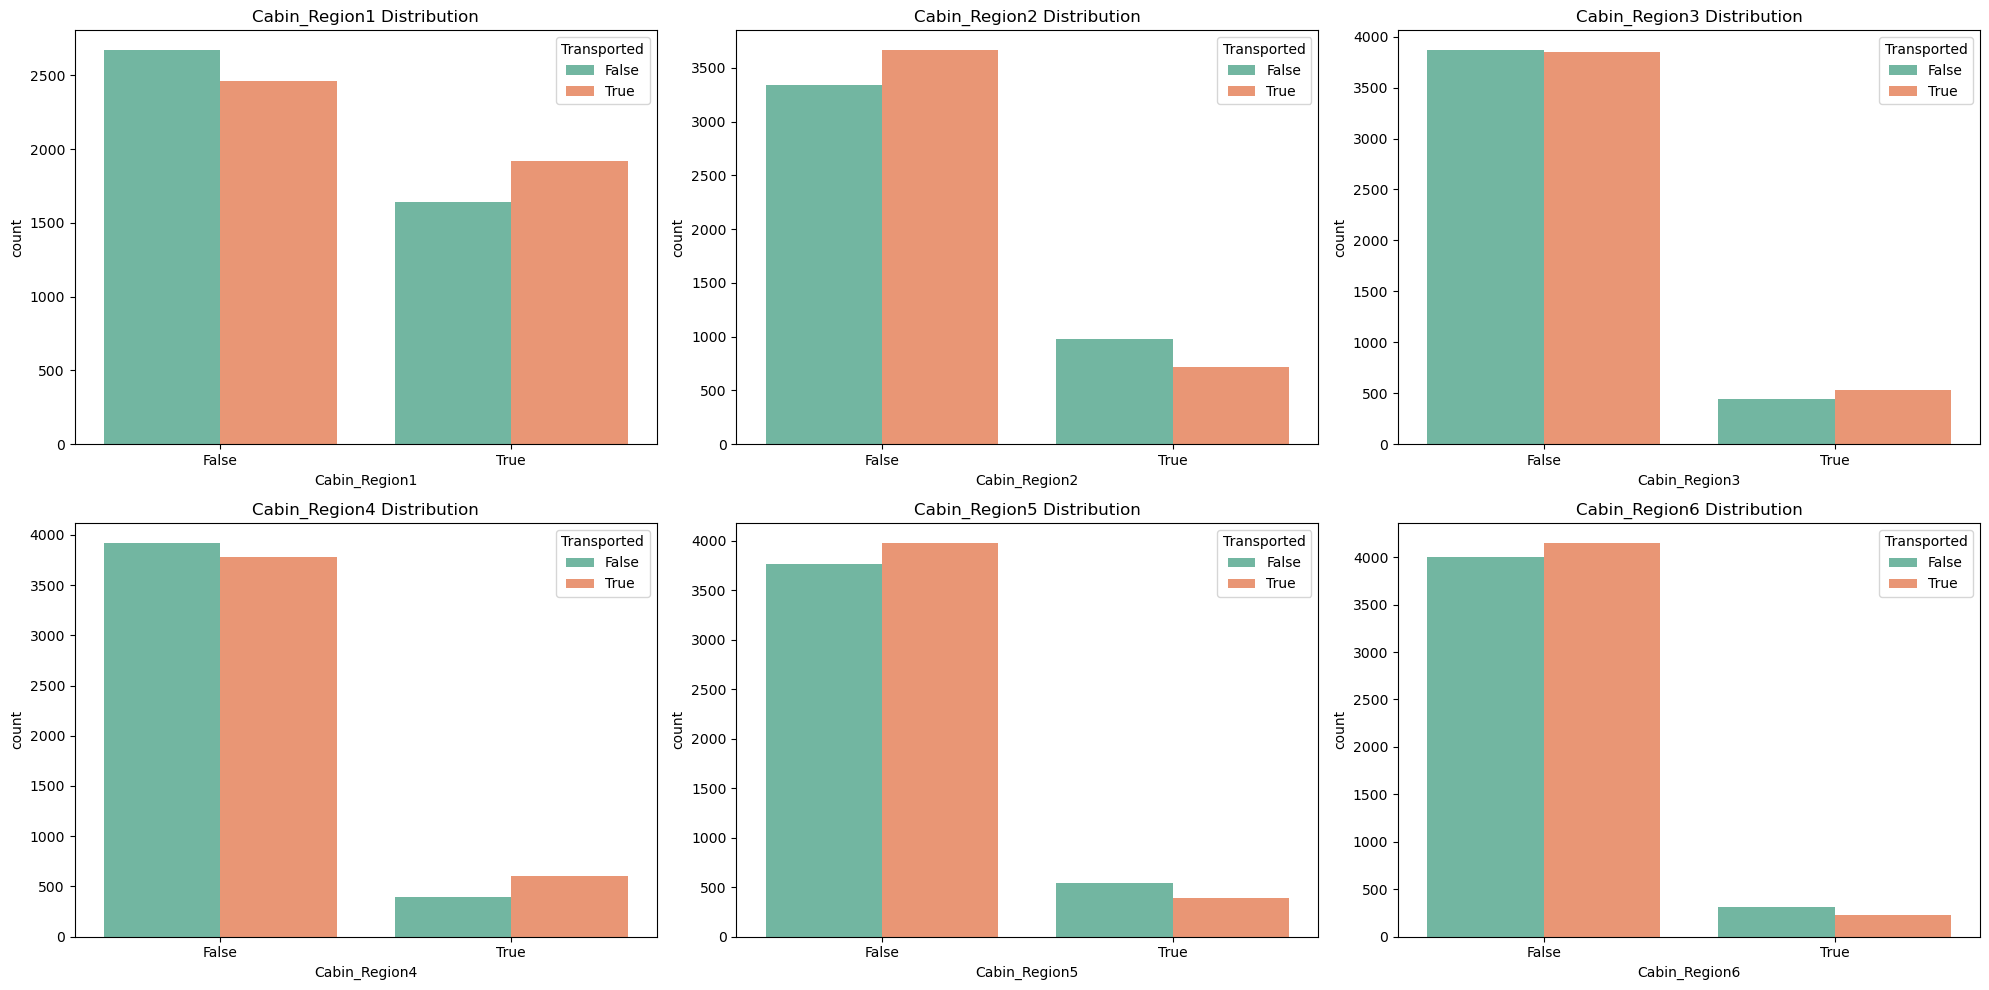

In [57]:
cols = ["Cabin_Region1","Cabin_Region2","Cabin_Region3","Cabin_Region4","Cabin_Region5","Cabin_Region6"]

plt.figure(figsize=(20,10))

for idx,value in enumerate(cols):
    plt.subplot(2,3,idx+1)
    sns.countplot(x=value, hue="Transported", data=train_df, palette="Set2")
    plt.title(f"{value} Distribution")
    plt.tight_layout()

### Observation
- Passengers from Cabin_Region1 are highly transported compared to other cabin regions.
- Additionally, there is a noticeable decrease in passenger transportation as the cabin region number increases.


### How we will do feature engineering on Age Feature
- After conducting Exploratory Data Analysis (EDA) on the Age feature, we gathered insights suggesting that ages can be categorized into different groups based on transportation.
- Therefore, we will create a new feature called Age Group and split the Age into different groups based on the insights gained from EDA.

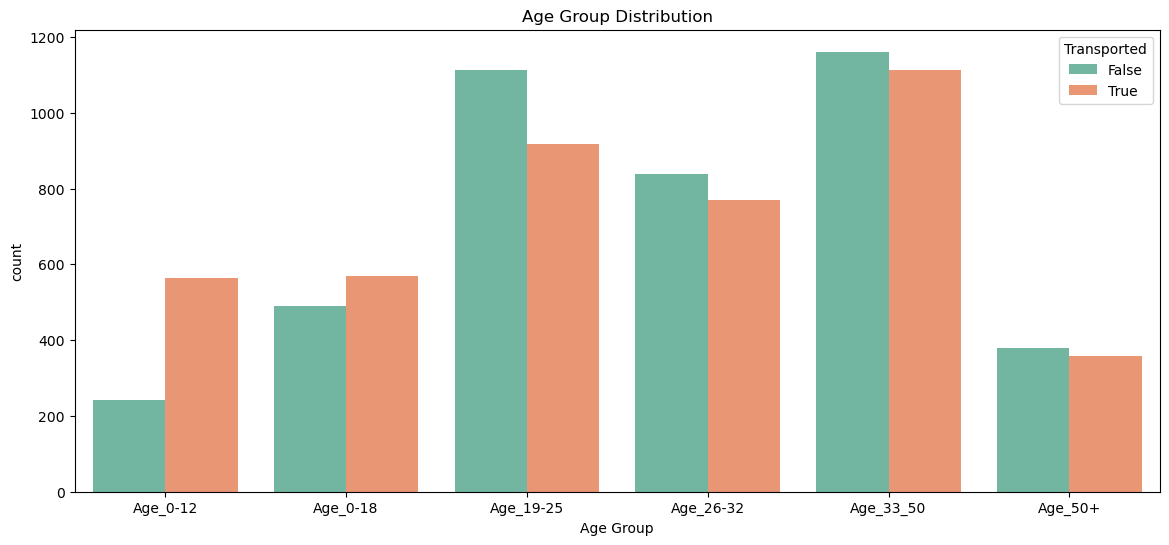

In [59]:
def age_group(df):
    age_group  = []
    for i in df["Age"]:
        if i<=12:
            age_group.append("Age_0-12")
        elif (i>12 and i<=18):
            age_group.append("Age_0-18")
        elif (i>18 and i<=25):
            age_group.append("Age_19-25")
        elif (i>25 and i<=32):
            age_group.append("Age_26-32")
        elif (i>32 and i<=50):
            age_group.append("Age_33_50")
        elif (i>50):
            age_group.append("Age_50+")
        else:
            age_group.append(np.nan)
        
    df["Age Group"] = age_group

age_group(train_df)
age_group(test_df)

order = sorted(train_df["Age Group"].value_counts().keys().to_list())

plt.figure(figsize=(14,6))
sns.countplot(x="Age Group",hue="Transported", data=train_df, palette="Set2",order=order)
plt.title("Age Group Distribution");

### Insights
- This new feature appears to be more relevant to our target data.
- Age groups 0-12 and 0-18 are more likely to be transported compared to not being transported.
- Age groups 19-25, 26-32, and 33-50 are less likely to be transported compared to not being transported.
- Age group 50+ is almost equally transported compared to not being transported.

### New All Expenditure Feature

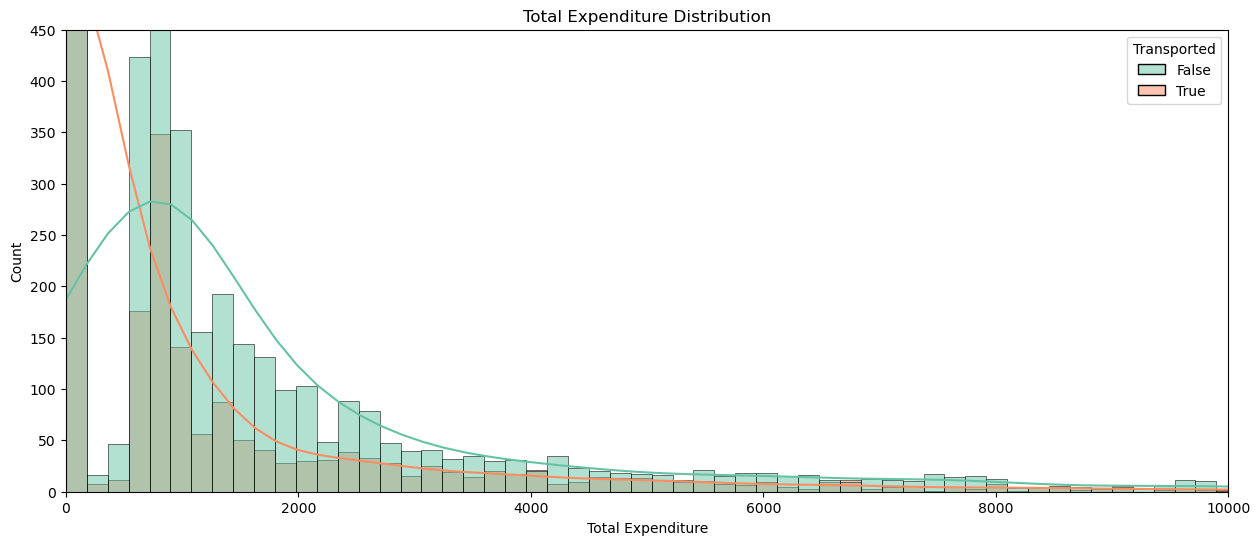

In [62]:
exp_cols = ["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]

def new_exp_features(df):
    df["Total Expenditure"] = df[exp_cols].sum(axis=1)
    df["No Spending"] = (df["Total Expenditure"]==0)

new_exp_features(train_df)
new_exp_features(test_df)

plt.figure(figsize=(15,6))
sns.histplot(x="Total Expenditure", hue="Transported", data=train_df, kde=True, palette="Set2",bins=200)
plt.ylim(0,450)
plt.xlim(0,10000)
plt.title("Total Expenditure Distribution");

In [63]:
mean = round(train_df["Total Expenditure"].mean())
median = train_df["Total Expenditure"].median()

print("Mean value of Total Expenditure feature is = ",mean)
print("Median value of Total Expenditure feature is = ",median)

Mean value of Total Expenditure feature is =  1441
Median value of Total Expenditure feature is =  716.0


### Insights

- Based on the measures of central tendency values provided above, we can categorize the Total Expenditure feature into different expense categories. 
- If Total Expenditure is equal to 0, it falls into the No Expense category.  
- If Total Expenditure is between 1 and 716, it falls into the Low Expense category.  
- If Total Expenditure is between 717 and 1441, it falls into the Medium Expense category.  
- If Total Expenditure is greater than 1441, it falls into the High Expense category.  

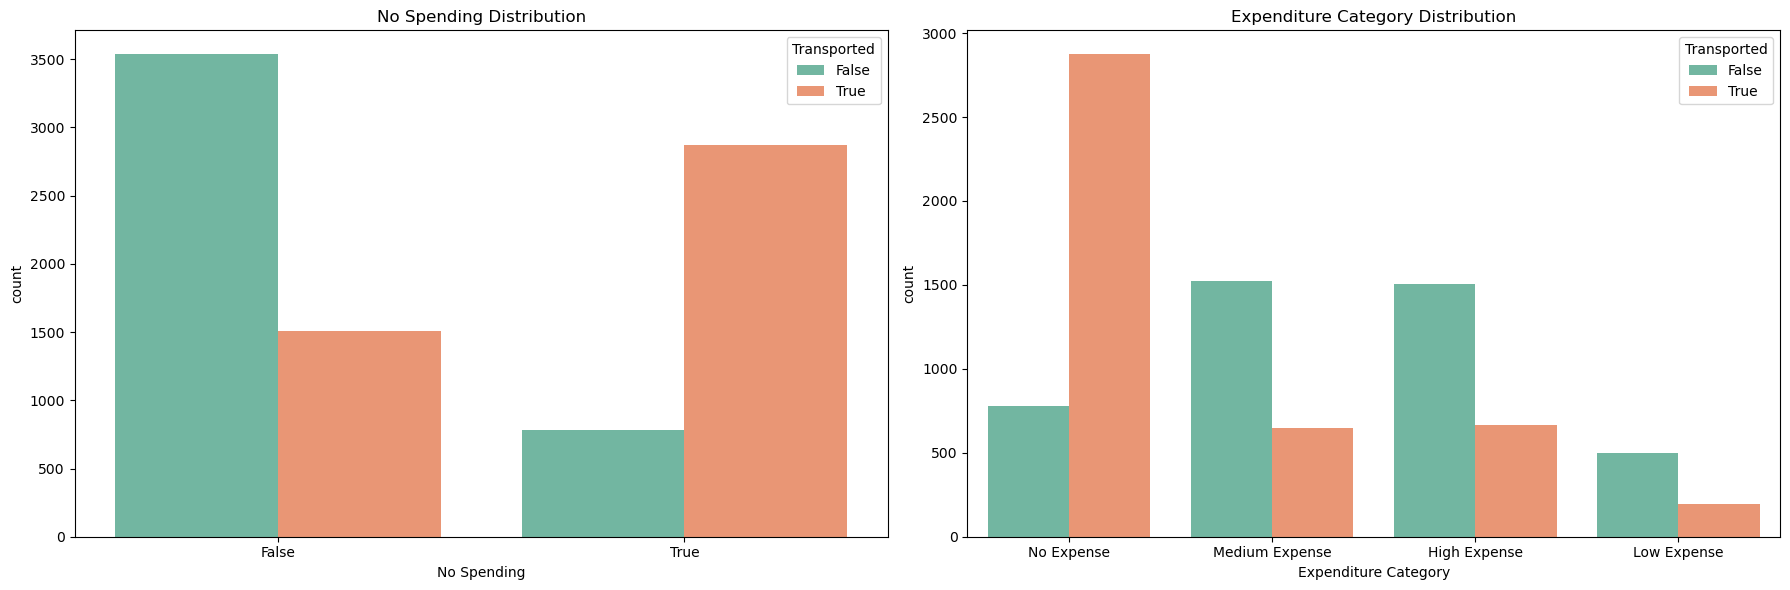

In [64]:
def expenditure_category(df):
    expense_category = []
    
    for i in df["Total Expenditure"]:
        if i==0:
            expense_category.append("No Expense")
        elif (i>0 and i<=716):
            expense_category.append("Low Expense")
        elif (i>716 and i<=1441):
            expense_category.append("Medium Expense")
        elif (i>1441):
            expense_category.append("High Expense")
    
    df["Expenditure Category"] = expense_category

expenditure_category(train_df)
expenditure_category(test_df)

cols = ["No Spending", "Expenditure Category"]

plt.figure(figsize=(18,6))
for idx,column in enumerate(cols):
    plt.subplot(1,2,idx+1)
    sns.countplot(x=column, hue="Transported", data=train_df, palette="Set2")
    plt.title(f"{column} Distribution")
    plt.tight_layout()

### Observation

  - Regarding the Total Expenditure feature, passengers with lower total expenses are more likely to be transported frequently.  
  - For the No Spending feature, passengers with no spending are observed to be transported at a high frequency.  
  - In the Expenditure Category feature, it's confirmed that passengers with no expenses are transported most frequently.  

# Final Data Preperation

In [65]:
cat_cols = train_df.select_dtypes(include=["object","bool"]).columns.tolist()
cat_cols.remove("Transported")
num_cols = train_df.select_dtypes(include=["int","float"]).columns.tolist()

print("Categorical Columns:",cat_cols)
print("\n","-"*120)
print("\nNumerical Columns:",num_cols)

Categorical Columns: ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name', 'Travelling_Solo', 'Cabin_Deck', 'Cabin_Side', 'Cabin_Region1', 'Cabin_Region2', 'Cabin_Region3', 'Cabin_Region4', 'Cabin_Region5', 'Cabin_Region6', 'Age Group', 'No Spending', 'Expenditure Category']

 ------------------------------------------------------------------------------------------------------------------------

Numerical Columns: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Group_Size', 'Total Expenditure']


### Impute missing values

In [66]:
imputer1 = SimpleImputer(strategy="most_frequent")     ##To fill Categorical Features.
imputer2 = SimpleImputer(strategy="median")            ##To fill numeircal features.

def fill_missingno(df):
    df[cat_cols] = imputer1.fit_transform(df[cat_cols])
    df[num_cols] = imputer2.fit_transform(df[num_cols])

fill_missingno(train_df)
fill_missingno(test_df)

print("Missing numbers left in train_df is:",train_df.isnull().sum().sum())
print("Missing numbers left in test_df is:",test_df.isnull().sum().sum())

Missing numbers left in train_df is: 0
Missing numbers left in test_df is: 0


### After feature engineering, drop data with high cardinality

In [67]:
print("Cardinality of features in numerical data is: ")
print(train_df.select_dtypes(include=["object"]).nunique())
print("\n","-"*50)
print("\nCardinality of features in categorical data is: ")
print(test_df.select_dtypes(include=["object"]).nunique())

# Extracting passengerId from test data because we need this for submitting our predictions on kaggle.
pass_df = test_df[["PassengerId"]]

cols = ["PassengerId","Cabin","Name"]
train_df.drop(columns =cols, inplace=True)
test_df.drop(columns=cols, inplace=True)

Cardinality of features in numerical data is: 
PassengerId             8693
HomePlanet                 3
CryoSleep                  2
Cabin                   6561
Destination                3
VIP                        2
Name                    8473
Travelling_Solo            2
Cabin_Deck                 8
Cabin_Side                 2
Cabin_Region1              2
Cabin_Region2              2
Cabin_Region3              2
Cabin_Region4              2
Cabin_Region5              2
Cabin_Region6              2
Age Group                  6
No Spending                2
Expenditure Category       4
dtype: int64

 --------------------------------------------------

Cardinality of features in categorical data is: 
PassengerId             4277
HomePlanet                 3
CryoSleep                  2
Cabin                   3266
Destination                3
VIP                        2
Name                    4176
Travelling_Solo            2
Cabin_Deck                 8
Cabin_Side               

In [68]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,8693.0,28.790291,14.341404,0.0,20.0,27.0,37.0,79.0
RoomService,8693.0,220.009318,660.519050,0.0,0.0,0.0,41.0,14327.0
FoodCourt,8693.0,448.434027,1595.790627,0.0,0.0,0.0,61.0,29813.0
ShoppingMall,8693.0,169.572300,598.007164,0.0,0.0,0.0,22.0,23492.0
Spa,8693.0,304.588865,1125.562559,0.0,0.0,0.0,53.0,22408.0
VRDeck,8693.0,298.261820,1134.126417,0.0,0.0,0.0,40.0,24133.0
Group_Size,8693.0,2.035546,1.596347,1.0,1.0,1.0,3.0,8.0
Total Expenditure,8693.0,1440.866329,2803.045694,0.0,0.0,716.0,1441.0,35987.0


### Observation
-   We observe that in RoomService, FoodCourt, ShoppingMall, Spa, and VRDeck, more than 50% of the data are equal to 0.
-   It was found that these features exhibit a right-skewed distribution.
-   Hence, it can be inferred that there is a significant presence of outliers in these features.
-   To address this issue, we propose transforming these features to a normal distribution using Log Transformation.
-   Since we are applying log transformation to these expenditure features, it's necessary to also apply the transformation to Total Expenditure.
-   This ensures that the model can better discern patterns within the data.


In [69]:
cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Total Expenditure']

for value in cols:
    train_df[value] = np.log(1+train_df[value])
    test_df[value]=np.log(1+test_df[value])

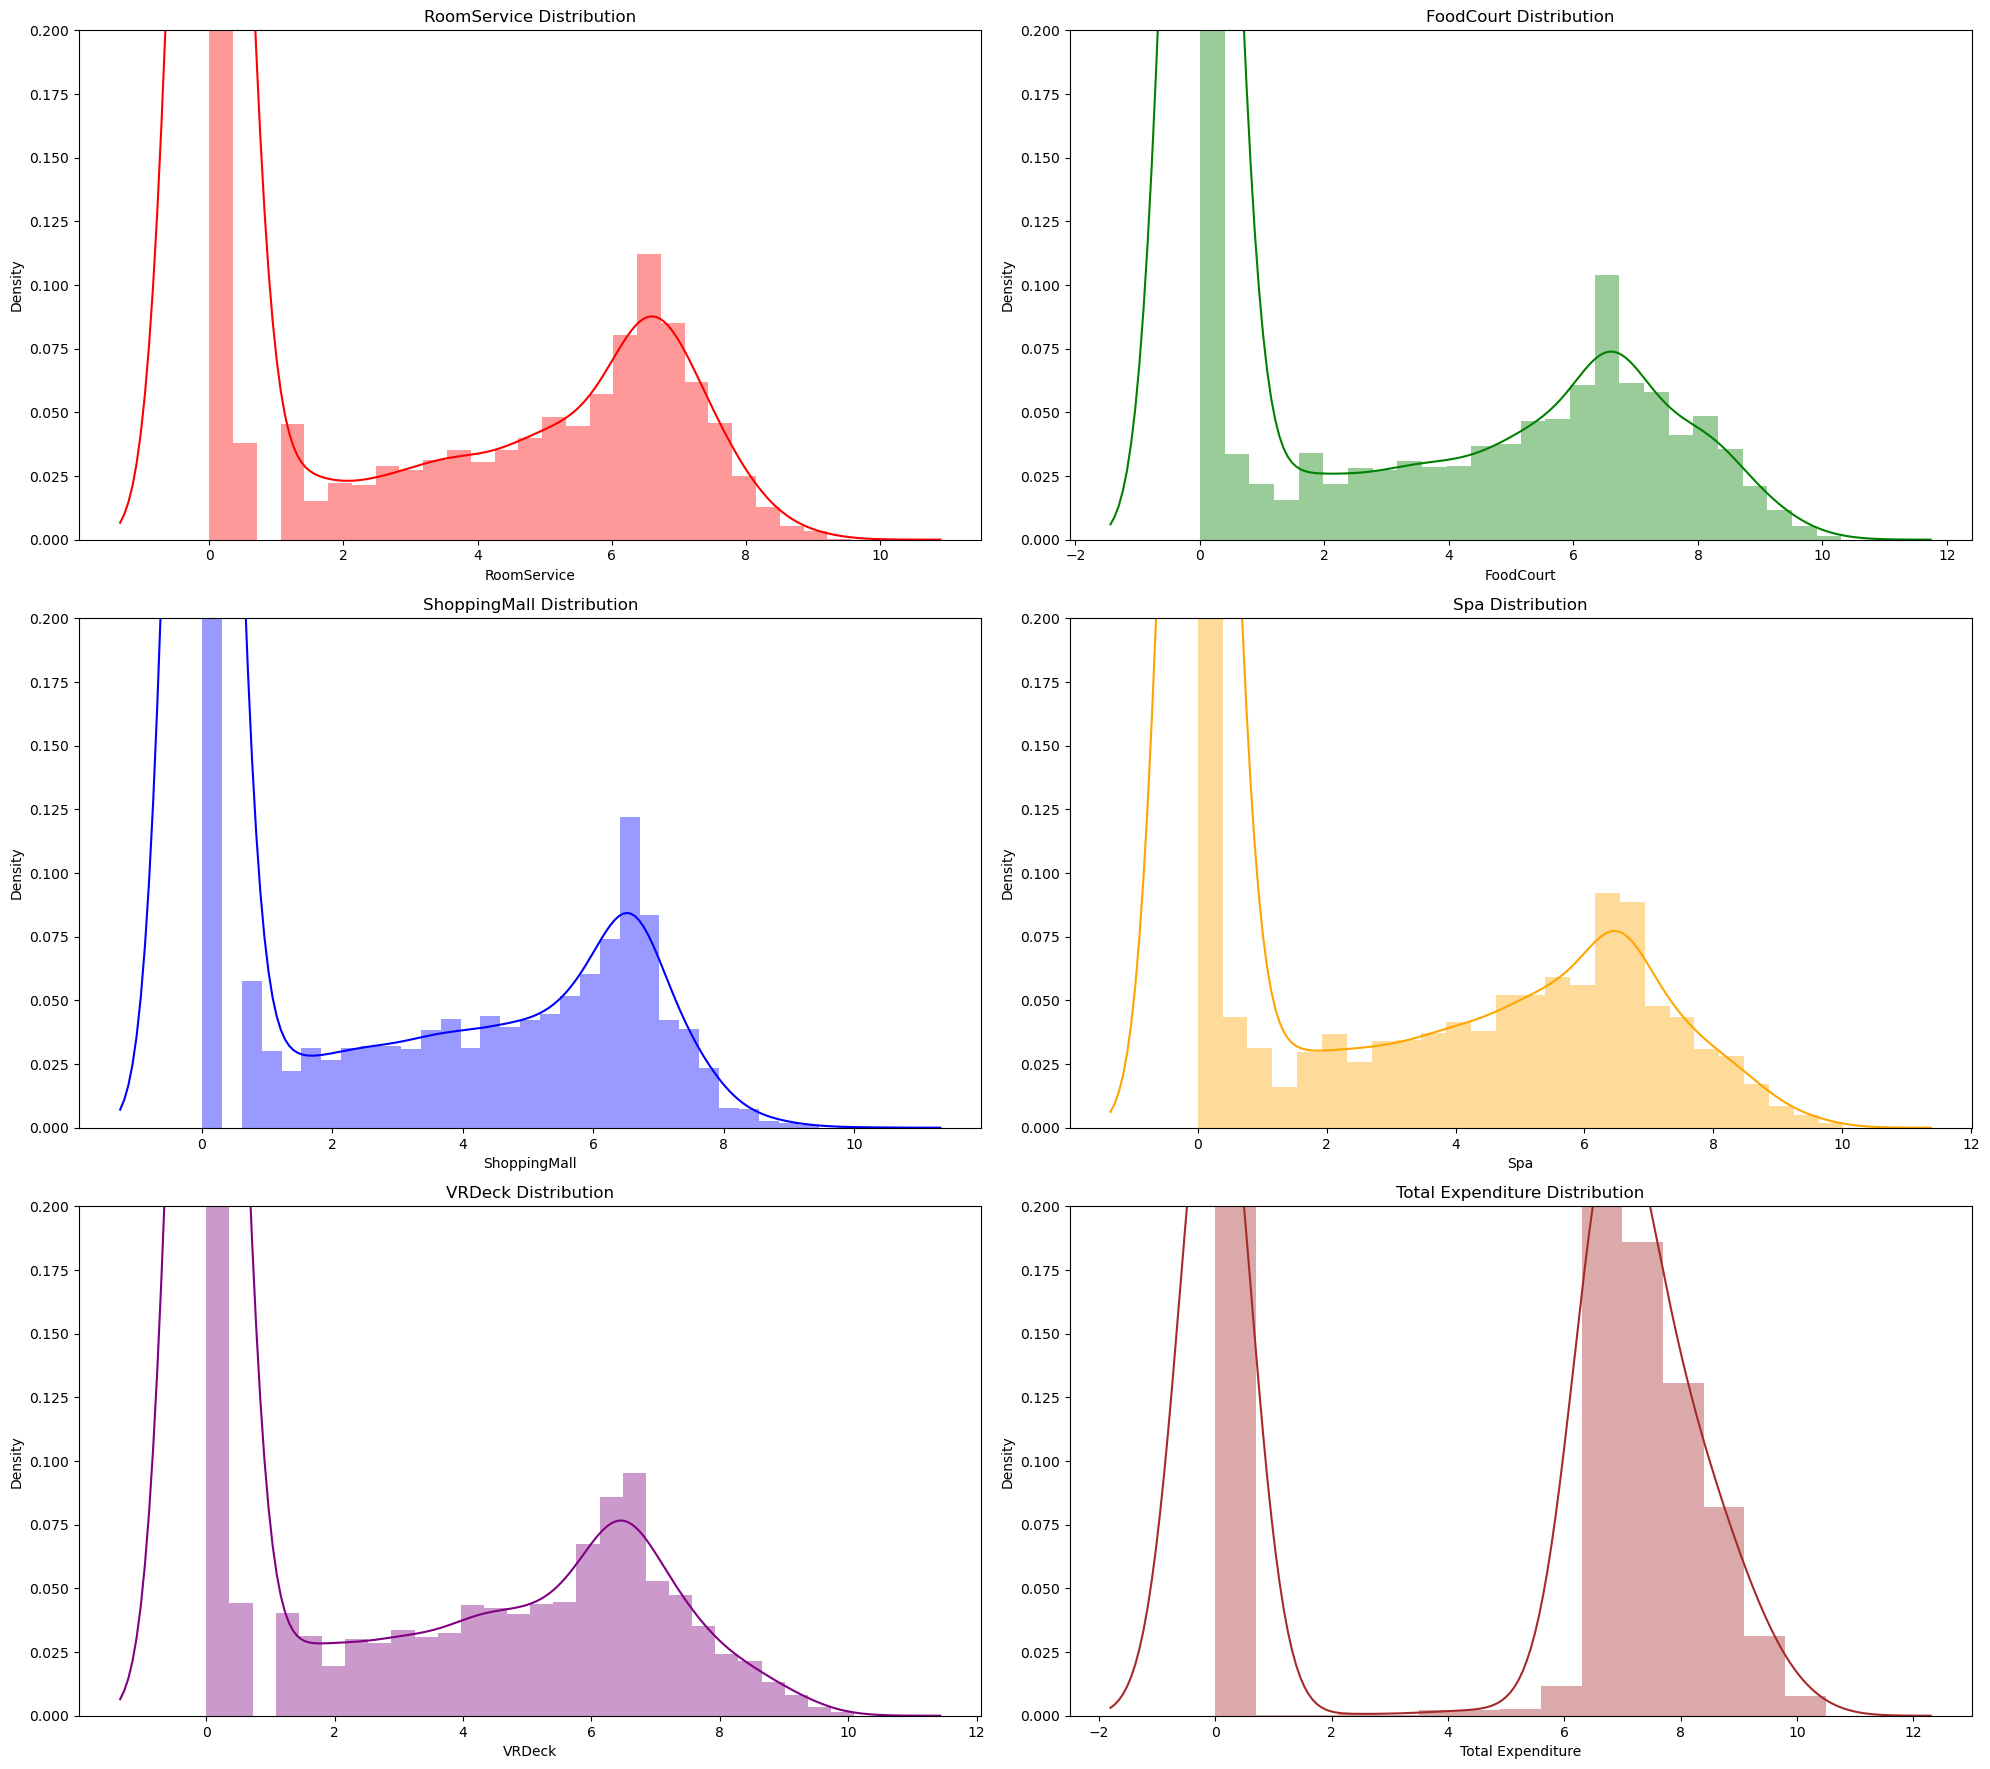

In [73]:
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown']

plt.figure(figsize=(20,35))
x=1

for i, color in zip(cols, colors):
    plt.subplot(6, 2, x)
    sns.distplot(train_df[i], color=color)  
    plt.ylim(0, 0.2)
    plt.title(f"{i} Distribution")
    plt.tight_layout()
    x += 1 

In [74]:
train_df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,Cabin_Region1,Cabin_Region2,Cabin_Region3,Cabin_Region4,Cabin_Region5,Cabin_Region6,Age Group,Total Expenditure,No Spending,Expenditure Category
0,Europa,False,TRAPPIST-1e,39.0,False,0.000000,0.000000,0.000000,0.000000,0.000000,...,True,False,False,False,False,False,Age_33_50,0.000000,True,No Expense
1,Earth,False,TRAPPIST-1e,24.0,False,4.700480,2.302585,3.258097,6.309918,3.806662,...,True,False,False,False,False,False,Age_19-25,6.602588,False,Medium Expense
2,Europa,False,TRAPPIST-1e,58.0,True,3.784190,8.182280,0.000000,8.812248,3.912023,...,True,False,False,False,False,False,Age_50+,9.248021,False,High Expense
3,Europa,False,TRAPPIST-1e,33.0,False,0.000000,7.157735,5.918894,8.110728,5.267858,...,True,False,False,False,False,False,Age_33_50,8.551981,False,High Expense
4,Earth,False,TRAPPIST-1e,16.0,False,5.717028,4.262680,5.023881,6.338594,1.098612,...,True,False,False,False,False,False,Age_0-18,6.995766,False,Medium Expense


### Changing Data-Type to Boolean

In [75]:
cols = ["CryoSleep","VIP","Travelling_Solo","No Spending","Cabin_Region1","Cabin_Region2","Cabin_Region3","Cabin_Region4",
       "Cabin_Region5","Cabin_Region6"]

train_df[cols] = train_df[cols].astype(bool)
test_df[cols] = test_df[cols].astype(bool)

### Feature Encoding

- We will do **One Hot Encoding** for nominal categorical features.
- We will do **LabelEncoding** for ordinal categorical features.

In [76]:
nominal_cat_cols = ["HomePlanet","Destination"]
ordinal_cat_cols = ["CryoSleep","VIP","Travelling_Solo","Cabin_Deck","Cabin_Side","Cabin_Region1","Cabin_Region2",
                    "Cabin_Region3","Cabin_Region4","Cabin_Region5","Cabin_Region6","Age Group","No Spending",
                    "Expenditure Category"]

# Label encoding
enc = LabelEncoder()

train_df[ordinal_cat_cols] = train_df[ordinal_cat_cols].apply(enc.fit_transform)
test_df[ordinal_cat_cols] = test_df[ordinal_cat_cols].apply(enc.fit_transform)

# One-hot encoding
train_df = pd.get_dummies(train_df,columns=nominal_cat_cols)
test_df = pd.get_dummies(test_df,columns=nominal_cat_cols)

train_df["Transported"].replace({False:0,True:1},inplace=True)

In [77]:
train_df.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Travelling_Solo,...,Age Group,Total Expenditure,No Spending,Expenditure Category,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0,39.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,...,4,0.000000,1,3,False,True,False,False,False,True
1,0,24.0,0,4.700480,2.302585,3.258097,6.309918,3.806662,1,1,...,2,6.602588,0,2,True,False,False,False,False,True
2,0,58.0,1,3.784190,8.182280,0.000000,8.812248,3.912023,0,0,...,5,9.248021,0,0,False,True,False,False,False,True
3,0,33.0,0,0.000000,7.157735,5.918894,8.110728,5.267858,0,0,...,4,8.551981,0,0,False,True,False,False,False,True
4,0,16.0,0,5.717028,4.262680,5.023881,6.338594,1.098612,1,1,...,1,6.995766,0,2,True,False,False,False,False,True


### Now create training data sets

In [78]:
# Split data for training models 
X = train_df.drop(columns=["Transported"])
y = train_df[["Transported"]]

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

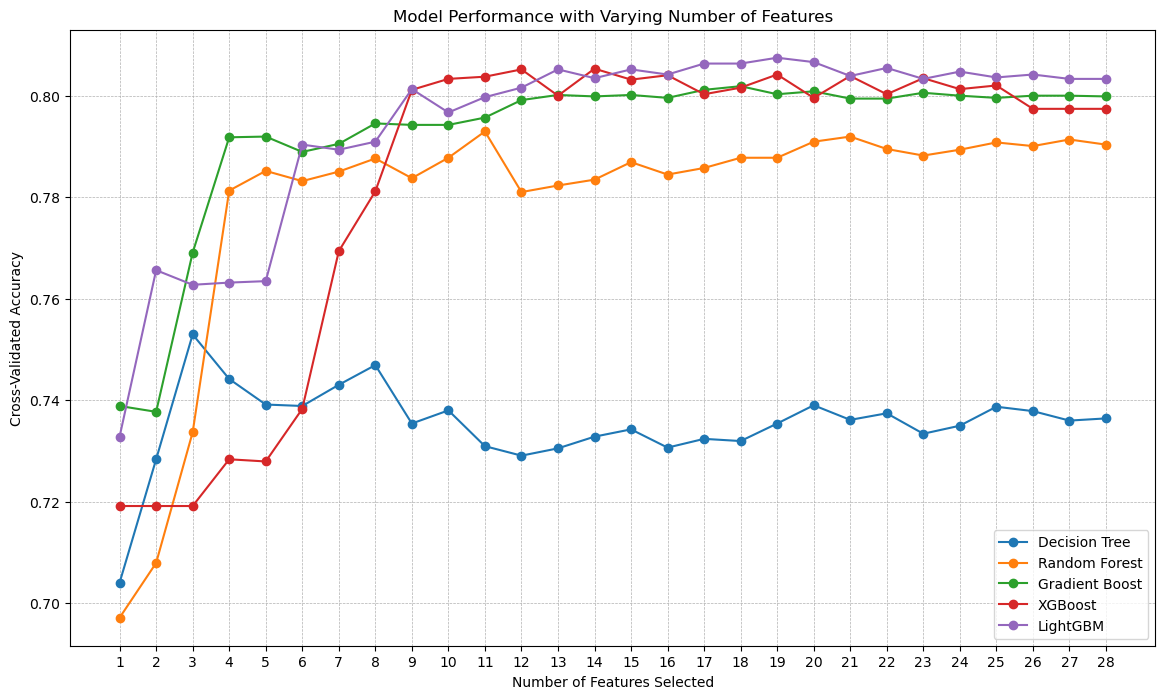

Features that give highest accuracy (per model):


,Model,Number of Features,Mean Accuracy,Selected Features
2,Decision Tree,3,0.752947,"FoodCourt, ShoppingMall, Total Expenditure"
73,Gradient Boost,18,0.801842,"CryoSleep, Age, RoomService, FoodCourt, Shoppi..."
130,LightGBM,19,0.807449,"CryoSleep, Age, RoomService, FoodCourt, Shoppi..."
38,Random Forest,11,0.792925,"CryoSleep, Age, RoomService, FoodCourt, Shoppi..."
97,XGBoost,14,0.805291,"CryoSleep, RoomService, FoodCourt, ShoppingMal..."


In [80]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.feature_selection import RFE
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

# Define your models here
models_optim = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boost": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42, verbose=-1)
}

data = []

feature_counts = range(1, 29)  # Assuming you want to test from 1 to 11 features

# Prepare the plot
plt.figure(figsize=(14, 8))

# Iterate over each model
for name, model in models_optim.items():
    mean_scores = []
    
    for n_features in feature_counts:
        # RFE with the current model and number of features
        selector = RFE(model, n_features_to_select=n_features, step=1)
        selector = selector.fit(x_train, y_train)
        
        # Train the model with selected features and assess performance using cross-validation
        scores = cross_val_score(model, x_train[x_train.columns[selector.support_]], y_train, cv=5, scoring='accuracy')
        mean_score = np.mean(scores)
        mean_scores.append(mean_score)
        
        # Store model name, number of features, mean accuracy, and selected features
        data.append({
            "Model": name,
            "Number of Features": n_features,
            "Mean Accuracy": mean_score,
            "Selected Features": ", ".join(x_train.columns[selector.support_])
        })
    
    # Plotting the results for the current model
    plt.plot(feature_counts, mean_scores, marker='o', label=name)


# Finalizing the plot
plt.title('Model Performance with Varying Number of Features')
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross-Validated Accuracy')
plt.xticks(feature_counts)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# Convert the list of data into a DataFrame
results_df = pd.DataFrame(data)

# Group by 'Model' and find the index of the max 'Mean Accuracy' for each group
idx = results_df.groupby('Model')['Mean Accuracy'].idxmax()

# Use the cleaned idx to select the rows with the highest mean accuracy for each model
highest_accuracy_rows = results_df.loc[idx]

print('Features that give highest accuracy (per model):')

# Display the rows with the highest mean accuracy for each model
display(highest_accuracy_rows)
